In [1]:
from matplotlib import pyplot as plt
import numpy as np
Nf = 1000
fmin = 1 # 1/micron => 300 THz
fmax = 2 # 1/micron => 600 THz
fre = np.linspace(fmin, fmax, Nf)
d = 0.5 # thickness = 500 nm 
epsi = 12
r = (np.sqrt(epsi) - 1)/( np.sqrt(epsi) + 1 )
R = np.abs(r**2)
F = 4 * R/(1 - R)**2

In [2]:
omega = 2 * np.pi * fre

In [3]:
import meep as mp

resolution = 100                # pixels/um
dpml = 1.0                      # PML thickness
sz = 16 + 2*dpml
cell_size = mp.Vector3(z=sz)
pml_layers = [mp.PML(dpml)]

fcen = (fmin+fmax)/2          # center frequency
df = (fmax-fmin)                  # frequency width
dimensions = 1

In [4]:
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df), component=mp.Ex, 
                     center=mp.Vector3(z=-8))]

In [5]:
sim_vac = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=sources,
                        dimensions=dimensions,
                        #Courant = 0.1,
                        resolution=resolution)

refl_fr = mp.FluxRegion(center=mp.Vector3(z=-8))
refl = sim_vac.add_flux(fcen, df, Nf, refl_fr)
tran_fr = mp.FluxRegion(center=mp.Vector3(z= 8 ))
tran = sim_vac.add_flux(fcen, df, Nf, tran_fr)
   
sim_vac.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex,
                                                        mp.Vector3(z=0), 1e-3))

empty_flux = mp.get_fluxes(tran)
empty_data = sim_vac.get_flux_data(refl)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000178099 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 18 with resolution 100
time for set_epsilon = 0.000438929 s
-----------
field decay(t = 50.005): 0.25052168984094575 / 0.25052168984094575 = 1.0
field decay(t = 100.01): 9.685451993563134e-16 / 0.25052168984094575 = 3.8661131496088625e-15
run 0 finished at t = 100.01 (20002 timesteps)


In [6]:
# add a block with n=3.5 for the air-dielectric interface
geometry = []
Np = 5 ## number of repeating
for i in range (Np):
    geometry.append(mp.Block(mp.Vector3(mp.inf,mp.inf,d), center=mp.Vector3(z = -3 + 0.6 * i),
                     material= mp.Medium(epsilon=epsi)))
    
sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        boundary_layers=pml_layers,
                        sources=sources,
                        #Courant = 0.1,
                        dimensions=dimensions,
                        resolution=resolution)
tran = sim.add_flux(fcen, df, Nf, tran_fr)
refl = sim.add_flux(fcen, df, Nf, refl_fr)
sim.load_minus_flux_data(refl, empty_data)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(z=0), 1e-3))

refl_flux = mp.get_fluxes(refl)
tran_flux = mp.get_fluxes(tran)
freqs = mp.get_flux_freqs(refl)

wvls = np.empty(Nf)
R = np.empty(Nf)
T = np.empty(Nf)
for i in range(Nf):
        wvls[i] = 1/freqs[i]
        R[i] = -refl_flux[i]/empty_flux[i]
        T[i] = tran_flux[i]/empty_flux[i]

-----------
Initializing structure...
time for choose_chunkdivision = 0.000102997 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 18 with resolution 100
     block, center = (0,0,-3)
          size (1e+20,1e+20,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,-2.4)
          size (1e+20,1e+20,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,-1.8)
          size (1e+20,1e+20,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,-1.2)
          size (1e+20,1e+20,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,-0.6)
          size (1e+20,1e+20,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for 

/home/mark/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mark/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


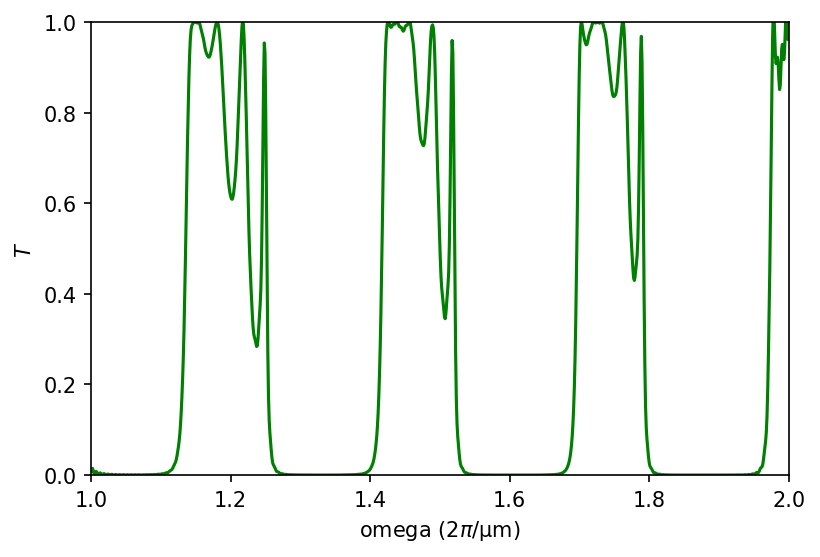

In [7]:
## compare numerical and analytical
plt.figure(dpi=150)
plt.plot(omega/2/np.pi,T,'g-',label='$T_{nur}$')
plt.xlabel("omega ($2\pi$/μm)")
plt.ylabel("$T$")
#plt.legend(loc="upper right")
plt.xlim([fmin,fmax])
plt.ylim([0,1])
plt.show()